# Feature Engineering

In [11]:
import pandas as pd
query = pd.read_csv("/Users/sks000y/Desktop/DHS/nutrition-data/testa.words.txt", header=None)
query.head(2)

,0
0,rustler soya less
1,pine nuts less sesame


In [ ]:
labels = pd.read_csv("/Users/sks000y/Desktop/DHS/nutrition-data/testa.tags.txt", header=None)
labels.head(2)

In [6]:
# Creating and segmeting the datasets

from collections import Counter
from pathlib import Path

MINCOUNT = 2
rel_path = "/Users/sks000y/Desktop/DHS/nutrition-data/"

if __name__ == '__main__':
    # 1. Words
    # Get Counter of words on all the data, filter by min count, save
    def words(name):
        return rel_path+'{}.words.txt'.format(name)

    print('Build vocab words (may take a while)')
    counter_words = Counter()
    for n in ['train', 'testa', 'testb']:
        with Path(words(n)).open() as f:
            for line in f:
                counter_words.update(line.strip().split())

    vocab_words = {w for w, c in counter_words.items() if c >= MINCOUNT}

    with Path(rel_path+'vocab.words.txt').open('w') as f:
        for w in sorted(list(vocab_words)):
            f.write('{}\n'.format(w))
    print('- done. Kept {} out of {}'.format(len(vocab_words), len(counter_words)))

    # 2. Chars
    # Get all the characters from the vocab words
    print('Build vocab chars')
    vocab_chars = set()
    for w in vocab_words:
        vocab_chars.update(w)

    with Path(rel_path+'vocab.chars.txt').open('w') as f:
        for c in sorted(list(vocab_chars)):
            f.write('{}\n'.format(c))
    print('- done. Found {} chars'.format(len(vocab_chars)))

    # 3. Tags
    # Get all tags from the training set

    def tags(name):
        return rel_path+'{}.tags.txt'.format(name)

    print('Build vocab tags (may take a while)')
    vocab_tags = set()
    with Path(tags('train')).open() as f:
        for line in f:
            vocab_tags.update(line.strip().split())

    with Path(rel_path+'vocab.tags.txt').open('w') as f:
        for t in sorted(list(vocab_tags)):
            f.write('{}\n'.format(t))
    print('- done. Found {} tags.'.format(len(vocab_tags)))

Build vocab words (may take a while)
- done. Kept 4504 out of 4505
Build vocab chars
- done. Found 49 chars
Build vocab tags (may take a while)
- done. Found 5 tags.


## Generating Glove Embedding

<h2>Global Vectors for Word Representation</h2>

#### <ul> Pre-trained word vector: 
<li>Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download): glove.6B.zip </li>
<li>Common Crawl (42B tokens, 1.9M vocab, uncased, 300d vectors, 1.75 GB download): glove.42B.300d.zip</li>
<b><li>Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download): glove.840B.300d.zip</li></b>
<li>Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): glove.twitter.27B.zip </li>
    </ul>

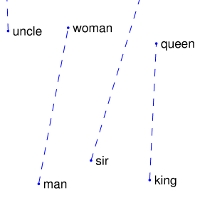

In [8]:
#Creating glove

"""Build an np.array from some glove file and some vocab file
You need to download `glove.840B.300d.txt` from
https://nlp.stanford.edu/projects/glove/ and you need to have built
your vocabulary first (Maybe using `build_vocab.py`)
"""


from pathlib import Path

import numpy as np

rel_path = "/Users/sks000y/Desktop/DHS/nutrition-data/"
glove_path = "/anaconda2/envs/NER/ner/GloVe-1.2/"

if __name__ == '__main__':
    # Load vocab
    with Path(rel_path+'vocab.words.txt').open() as f:
        word_to_idx = {line.strip(): idx for idx, line in enumerate(f)}
    size_vocab = len(word_to_idx)

    # Array of zeros
    embeddings = np.zeros((size_vocab, 300))

    # Get relevant glove vectors
    found = 0
    print('Reading GloVe file (may take a while)')
    with Path(glove_path+'glove.840B.300d.txt').open() as f:
        for line_idx, line in enumerate(f):
            if line_idx % 100000 == 0:
                print('- At line {}'.format(line_idx))
            line = line.strip().split()
            if len(line) != 300 + 1:
                continue
            word = line[0]
            embedding = line[1:]
            if word in word_to_idx:
                found += 1
                word_idx = word_to_idx[word]
                embeddings[word_idx] = embedding
    print('- done. Found {} vectors for {} words'.format(found, size_vocab))

    # Save np.array to file
    #np.savez_compressed(re_path+'glove.npz', embeddings=embeddings)

Reading GloVe file (may take a while)
- At line 0
- At line 100000
- At line 200000
- At line 300000
- At line 400000
- At line 500000
- At line 600000
- At line 700000
- At line 800000
- At line 900000
- At line 1000000
- At line 1100000
- At line 1200000
- At line 1300000
- At line 1400000
- At line 1500000
- At line 1600000
- At line 1700000
- At line 1800000
- At line 1900000
- At line 2000000
- At line 2100000
- done. Found 3795 vectors for 4504 words


In [9]:
# Save np.array to file
np.savez_compressed(rel_path+'glove.npz', embeddings=embeddings)

# Modelling

In [55]:
import tensorflow as tf
import functools
import json
import logging
from pathlib import Path
import sys
import io

import numpy as np
import tensorflow as tf
from tensorflow import metrics

DATADIR = '/Users/sks000y/Desktop/DHS/nutrition-data/'

# Logging
Path('results3').mkdir(exist_ok=True)
tf.logging.set_verbosity(logging.INFO)
handlers = [
    logging.FileHandler('results3/main.log'),
    logging.StreamHandler(sys.stdout)
]
logging.getLogger('tensorflow').handlers = handlers

import unicodedata

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def parse_fn(line_words, line_tags):
    # Encode in Bytes for TF
    words = [w.encode() for w in line_words.strip().split()]
    tags = [t.encode() for t in line_tags.strip().split()]
    assert len(words) == len(tags), "Words and tags lengths don't match"

    # Chars
    chars = [[c.encode() for c in w] for w in line_words.strip().split()]
    lengths = [len(c) for c in chars]
    max_len = max(lengths)
    chars = [c + [b'<pad>'] * (max_len - l) for c, l in zip(chars, lengths)]
    return ((words, len(words)), (chars, lengths)), tags


def generator_fn(words, tags):
    with Path(words).open('r') as f_words, Path(tags).open('r') as f_tags:
        for line_words, line_tags in zip(f_words, f_tags):
            yield parse_fn(strip_accents(line_words), strip_accents(line_tags))


def input_fn(words, tags, params=None, shuffle_and_repeat=False):
    params = params if params is not None else {}
    shapes = ((([None], ()),               # (words, nwords)
               ([None, None], [None])),    # (chars, nchars)
              [None])                      # tags
    types = (((tf.string, tf.int32),
              (tf.string, tf.int32)),
             tf.string)
    defaults = ((('<pad>', 0),
                 ('<pad>', 0)),
                'O')
    dataset = tf.data.Dataset.from_generator(
        functools.partial(generator_fn, words, tags),
        output_shapes=shapes, output_types=types)

    if shuffle_and_repeat:
        dataset = dataset.shuffle(params['buffer']).repeat(params['epochs'])

    dataset = (dataset
               .padded_batch(params.get('batch_size', 2500), shapes, defaults)
               .prefetch(1))
    return dataset

<h2>Tensorflow Estimator API </h2><h3> using custom Estimators and Tensorflow tf.data have been used for writing the code of all the training, modeling and evaluation.<br><br>
    
<li>Custom Estimator in Tensorflow has tf.estimator.Estimator class which wraps a model which is specified by a model_fnand tf.estimator.train_and_evaluate utility function which trains, evaluates, and (optionally) exports the model by using the given estimator.</li></h3>

In [56]:
def model_fn(features, labels, mode, params):
    # Read vocabs and inputs
    
    if isinstance(features, dict):
        features = ((features['words'], features['nwords']),
                    (features['chars'], features['nchars']))
    # Read vocabs and inputs
    dropout = params['dropout']
    (words, nwords), (chars, nchars) = features
    
    #Check whether training mode so as to make dropout activate/deactivate
    training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    
    vocab_words = tf.contrib.lookup.index_table_from_file(
        params['words'], num_oov_buckets=params['num_oov_buckets'])
    vocab_chars = tf.contrib.lookup.index_table_from_file(
        params['chars'], num_oov_buckets=params['num_oov_buckets'])
    
    with Path(params['tags']).open() as f:
        indices = [idx for idx, tag in enumerate(f) if tag.strip() != 'O']
        num_tags = len(indices) + 1
    with Path(params['chars']).open() as f:
        num_chars = sum(1 for _ in f) + params['num_oov_buckets']

    # Char Embeddings
    
    #For each sentence and words, we have a list of characters
    #We find the index of character present in the dictionary of all characters
    char_ids = vocab_chars.lookup(chars)  #[sentence, words, chars] 
    
    #Initialize a variable [total_number_of_chars, dimension of char_embedding=100] 
    #storing the initial embedding of all characters with some random floating point numbers
    variable = tf.get_variable(
        'chars_embeddings', [num_chars, params['dim_chars']], tf.float32)
    
    #Lookup the embeddings of the chars in char_ids 
    char_embeddings = tf.nn.embedding_lookup(variable, char_ids) #[sentence, word, chars, char_dim=100]
    
    char_embeddings = tf.layers.dropout(char_embeddings, rate=dropout,
                                        training=training)

    # Char LSTM
    
    #[max_length of sentences in batch]
    dim_words = tf.shape(char_embeddings)[1]
    #[max_length of words in all the sentences]
    dim_chars = tf.shape(char_embeddings)[2]
    
    #[sentence*max_words_in_sentence ,max_chars_in_all_words, char_dim=100]
    flat = tf.reshape(char_embeddings, [-1, dim_chars, params['dim_chars']]) 
    #making time major from batch major as required by tf.contrib.rnnt = 
    t = tf.transpose(flat, perm=[1, 0, 2])
    
    #Initializing LSTM each having 25 units
    lstm_cell_fw = tf.contrib.rnn.LSTMBlockFusedCell(params['char_lstm_size'])
    lstm_cell_bw = tf.contrib.rnn.LSTMBlockFusedCell(params['char_lstm_size'])
    
    #Creating backward dir LSTM
    lstm_cell_bw = tf.contrib.rnn.TimeReversedFusedRNN(lstm_cell_bw)
    
    #output having dim [max_chars_in_all_words, sentence*max_words_in_sentence, char_embd_size=25]
    #Here time_steps i.e.[sequence_length] = number of chars in each words
    _, (_, output_fw) = lstm_cell_fw(t, dtype=tf.float32,
                                     sequence_length=tf.reshape(nchars, [-1]))
    
    #Reverse Bi-LSTM output
    _, (_, output_bw) = lstm_cell_bw(t, dtype=tf.float32,
                                     sequence_length=tf.reshape(nchars, [-1]))
    
    #[max_chars_in_all_words, sentence*max_words_in_sentence, char_embd_size=25+25=50]
    output = tf.concat([output_fw, output_bw], axis=-1)
    
    #Reshape to [num_of_sentences, max_num_of_words, 50]
    char_embeddings = tf.reshape(output, [-1, dim_words, 50])
    
    

    # Word Embeddings
    
    #For each sentence, we have a list of words
    #We find the index of words present in the dictionary of all words
    word_ids = vocab_words.lookup(words) #[sentence, words]
    
    #Getting the glove embeddings of all the words
    glove = np.load(params['glove'])['embeddings']  # np.array
    
    #Appending an extra embeddings to return if some word is not found
    variable = np.vstack([glove, [[0.] * params['dim']]])
    variable = tf.Variable(variable, dtype=tf.float32, trainable=False)
    #Look up the word embeddings in the dictionary we created as non-trainable
    word_embeddings = tf.nn.embedding_lookup(variable, word_ids, validate_indices=False)

    # Concatenate Word and Char Embeddings
    embeddings = tf.concat([word_embeddings, char_embeddings], axis=-1)
    embeddings = tf.layers.dropout(embeddings, rate=dropout, training=training)

    
    
    # LSTM
    
    #Time major, input shape= [sentences, words, 350]
    t = tf.transpose(embeddings, perm=[1, 0, 2])  # Need time-major
    #Forward and Backward lstm each of 100 units
    lstm_cell_fw = tf.contrib.rnn.LSTMBlockFusedCell(params['lstm_size'])
    lstm_cell_bw = tf.contrib.rnn.LSTMBlockFusedCell(params['lstm_size'])
    lstm_cell_bw = tf.contrib.rnn.TimeReversedFusedRNN(lstm_cell_bw)
    
    # time steps i.e. [sequence_length] having number of words in each sentence
    output_fw, _ = lstm_cell_fw(t, dtype=tf.float32, sequence_length=nwords) #[sentence, words, 100]
    output_bw, _ = lstm_cell_bw(t, dtype=tf.float32, sequence_length=nwords) #[sentence, words, 100]
    
    # Concatenate the both forward and backword encoding 
    output = tf.concat([output_fw, output_bw], axis=-1) #[sentence, words, 100+100=200]
    output = tf.transpose(output, perm=[1, 0, 2]) #transponse to original shape
    output = tf.layers.dropout(output, rate=dropout, training=training)

    #Create a dense layer to reduce the output to num of tags
    logits = tf.layers.dense(output, num_tags) # [sentence, word, num_of_tag=6]
    
    #CRF
    
    #Create a variable and initialize as a transition score from one tags to another tags
    #in determining the score of a particular combination of tags
    crf_params = tf.get_variable("crf", [num_tags, num_tags], dtype=tf.float32)
    
    # determining the tags for each sentence # [sentence, no_of_tags]
    pred_ids, _ = tf.contrib.crf.crf_decode(logits, crf_params, nwords)

    if mode == tf.estimator.ModeKeys.PREDICT:
        # Predictions
        reverse_vocab_tags = tf.contrib.lookup.index_to_string_table_from_file(
            params['tags'])
        pred_strings = reverse_vocab_tags.lookup(tf.to_int64(pred_ids))
        predictions = {
            'pred_ids': pred_ids,
            'tags': pred_strings
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    else:
        # Loss
        vocab_tags = tf.contrib.lookup.index_table_from_file(params['tags'],default_value=0)
        tags = vocab_tags.lookup(labels)
        log_likelihood, _ = tf.contrib.crf.crf_log_likelihood(
            logits, tags, nwords, crf_params)
        loss = tf.reduce_mean(-log_likelihood)

        # Metrics
        weights = tf.sequence_mask(nwords)
        metrics = {
            'acc': tf.metrics.accuracy(tags, pred_ids, weights)
        }
        for metric_name, op in metrics.items():
            tf.summary.scalar(metric_name, op[1])

        if mode == tf.estimator.ModeKeys.EVAL:
            return tf.estimator.EstimatorSpec(
                mode, loss=loss, eval_metric_ops=metrics)

        elif mode == tf.estimator.ModeKeys.TRAIN:
            train_op = tf.train.AdamOptimizer().minimize(
                loss, global_step=tf.train.get_or_create_global_step())
            return tf.estimator.EstimatorSpec(
                mode, loss=loss, train_op=train_op)


In [57]:
if __name__ == '__main__':
    # Params
    params = {
        'dim': 300,
        'dim_chars': 100,
        'dropout': 0.5,
        'num_oov_buckets': 1,
        'epochs': 1,
        'batch_size': 500,
        'buffer': 15000,
        'char_lstm_size': 25,
        'lstm_size': 100,
        'words': str(Path(DATADIR, 'vocab.words.txt')),
        'chars': str(Path(DATADIR, 'vocab.chars.txt')),
        'tags': str(Path(DATADIR, 'vocab.tags.txt')),
        'glove': str(Path(DATADIR, 'glove.npz'))
    }
    with io.open("results3/params.json",'w',encoding="utf-8") as outfile:
        outfile.write(json.dumps(params, ensure_ascii=False))

    def fwords(name):
        return str(Path(DATADIR, '{}.words.txt'.format(name)))

    def ftags(name):
        return str(Path(DATADIR, '{}.tags.txt'.format(name)))

    # Estimator, train and evaluate
    train_inpf = functools.partial(input_fn, fwords('train'), ftags('train'),
                                   params, shuffle_and_repeat=True)
    eval_inpf = functools.partial(input_fn, fwords('testa'), ftags('testa'))

    cfg = tf.estimator.RunConfig(save_checkpoints_secs=120)
    #ws = tf.estimator.WarmStartSettings(ckpt_to_initialize_from='/content/results3/model')
    estimator = tf.estimator.Estimator(model_fn, DATADIR+'results3/model', cfg, params)
    Path(estimator.eval_dir()).mkdir(parents=True, exist_ok=True)
   # hook = tf.contrib.estimator.stop_if_no_increase_hook(
   #     estimator, 'acc', 500, min_steps=2000, run_every_secs=120)
    train_spec = tf.estimator.TrainSpec(input_fn=train_inpf)
    eval_spec = tf.estimator.EvalSpec(input_fn=eval_inpf, throttle_secs=120)
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)


Using config: {'_model_dir': '/Users/sks000y/Desktop/DHS/nutrition-data/results3/model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x14a4543c8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I1007 13:27:56.570362 4614768064 estimator.py:209] Using config: {'_model_dir': '/Users/sks000y/Desktop/DHS/nutrition-data/results3/model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x14a4543c8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Not using Distribute Coordinator.


I1007 13:27:56.572524 4614768064 estimator_training.py:186] Not using Distribute Coordinator.


Running training and evaluation locally (non-distributed).


I1007 13:27:56.573843 4614768064 training.py:612] Running training and evaluation locally (non-distributed).


Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 120.


I1007 13:27:56.575311 4614768064 training.py:700] Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 120.


Calling model_fn.


I1007 13:27:56.626874 4614768064 estimator.py:1145] Calling model_fn.


Done calling model_fn.


I1007 13:27:58.744024 4614768064 estimator.py:1147] Done calling model_fn.


Create CheckpointSaverHook.


I1007 13:27:58.746921 4614768064 basic_session_run_hooks.py:541] Create CheckpointSaverHook.


Graph was finalized.


I1007 13:27:58.880584 4614768064 monitored_session.py:240] Graph was finalized.


Restoring parameters from /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt-862


I1007 13:27:58.884063 4614768064 saver.py:1280] Restoring parameters from /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt-862


Running local_init_op.


I1007 13:27:59.072805 4614768064 session_manager.py:500] Running local_init_op.


Done running local_init_op.


I1007 13:27:59.117530 4614768064 session_manager.py:502] Done running local_init_op.


Saving checkpoints for 862 into /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt.


I1007 13:28:01.216736 4614768064 basic_session_run_hooks.py:606] Saving checkpoints for 862 into /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt.


loss = 0.017627865, step = 863


I1007 13:28:04.919068 4614768064 basic_session_run_hooks.py:262] loss = 0.017627865, step = 863


global_step/sec: 2.55166


I1007 13:28:44.108973 4614768064 basic_session_run_hooks.py:692] global_step/sec: 2.55166


loss = 0.019387666, step = 963 (39.191 sec)


I1007 13:28:44.110518 4614768064 basic_session_run_hooks.py:260] loss = 0.019387666, step = 963 (39.191 sec)


global_step/sec: 2.44516


I1007 13:29:25.006165 4614768064 basic_session_run_hooks.py:692] global_step/sec: 2.44516


loss = 0.006845953, step = 1063 (40.897 sec)


I1007 13:29:25.007909 4614768064 basic_session_run_hooks.py:260] loss = 0.006845953, step = 1063 (40.897 sec)


Saving checkpoints for 1102 into /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt.


I1007 13:29:42.429743 4614768064 basic_session_run_hooks.py:606] Saving checkpoints for 1102 into /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt.


Calling model_fn.


I1007 13:29:42.781968 4614768064 estimator.py:1145] Calling model_fn.


Done calling model_fn.


I1007 13:29:43.720898 4614768064 estimator.py:1147] Done calling model_fn.


Starting evaluation at 2019-10-07T13:29:43Z


I1007 13:29:43.748197 4614768064 evaluation.py:255] Starting evaluation at 2019-10-07T13:29:43Z


Graph was finalized.


I1007 13:29:44.042522 4614768064 monitored_session.py:240] Graph was finalized.


Restoring parameters from /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt-1102


I1007 13:29:44.046168 4614768064 saver.py:1280] Restoring parameters from /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt-1102


Running local_init_op.


I1007 13:29:44.148252 4614768064 session_manager.py:500] Running local_init_op.


Done running local_init_op.


I1007 13:29:44.180175 4614768064 session_manager.py:502] Done running local_init_op.


Evaluation [10/100]


I1007 13:29:46.417123 4614768064 evaluation.py:167] Evaluation [10/100]


Evaluation [20/100]


I1007 13:29:48.296336 4614768064 evaluation.py:167] Evaluation [20/100]


Evaluation [30/100]


I1007 13:29:50.119359 4614768064 evaluation.py:167] Evaluation [30/100]


Evaluation [40/100]


I1007 13:29:51.897351 4614768064 evaluation.py:167] Evaluation [40/100]


Finished evaluation at 2019-10-07-13:29:51


I1007 13:29:51.952627 4614768064 evaluation.py:275] Finished evaluation at 2019-10-07-13:29:51


Saving dict for global step 1102: acc = 0.99987864, global_step = 1102, loss = 0.0018811794


I1007 13:29:51.954382 4614768064 estimator.py:2039] Saving dict for global step 1102: acc = 0.99987864, global_step = 1102, loss = 0.0018811794


Saving 'checkpoint_path' summary for global step 1102: /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt-1102


I1007 13:29:51.956799 4614768064 estimator.py:2099] Saving 'checkpoint_path' summary for global step 1102: /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt-1102


Loss for final step: 0.013478433.


I1007 13:29:51.993923 4614768064 estimator.py:368] Loss for final step: 0.013478433.


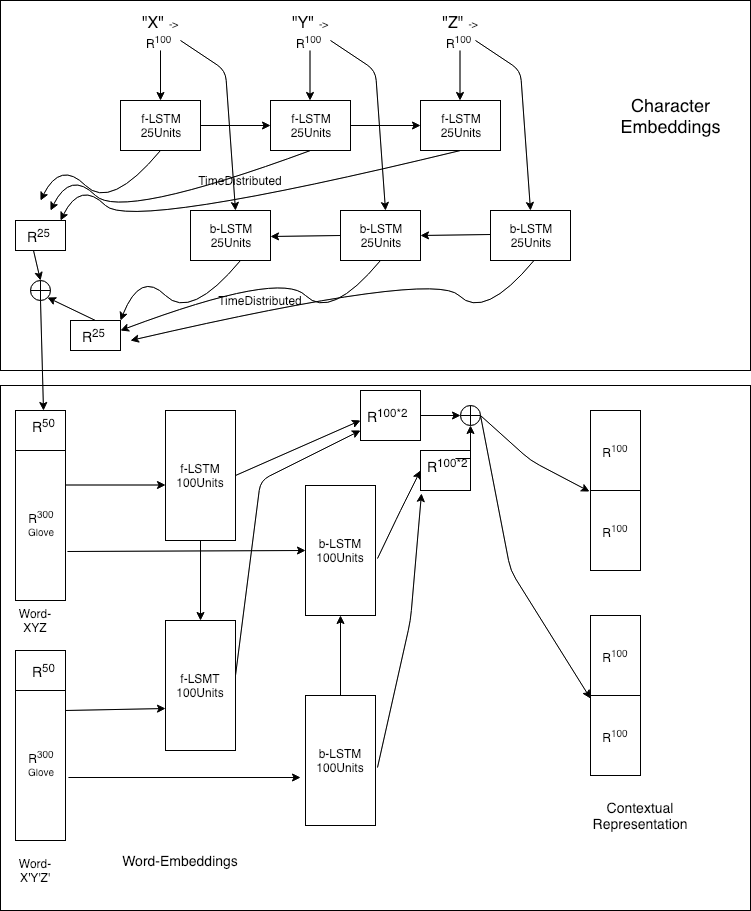

# Prediction

In [36]:
def parse_fn_loc(line_words, line_tags):
   # Encode in Bytes for TF
    words = [w.encode() for w in line_words.strip().split()]
    tags = [t.encode() for t in line_tags.strip().split()]
    assert len(words) == len(tags), "Words and tags lengths don't match"

    # Chars
    chars = [[c.encode() for c in w] for w in line_words.strip().split()]
    lengths = [len(c) for c in chars]
    max_len = max(lengths)
    chars = [c + [b'<pad>'] * (max_len - l) for c, l in zip(chars, lengths)]
    yield ((words, len(words)), (chars, lengths)), tags    

def input_fn_loc(words, tags, params=None):
    params = params if params is not None else {}
    shapes = ((([None], ()),               # (words, nwords)
               ([None, None], [None])),    # (chars, nchars)
              [None])                      # tags
    types = (((tf.string, tf.int32),
              (tf.string, tf.int32)),
             tf.string)
    defaults = ((('<pad>', 0),
                 ('<pad>', 0)),
                'O')
    dataset = tf.data.Dataset.from_generator(
        functools.partial(parse_fn_loc, words, tags),
        output_shapes=shapes, output_types=types)

    dataset = (dataset
               .padded_batch(params.get('batch_size', 2500), shapes, defaults)
               .prefetch(1))
    return dataset

In [69]:
import functools
test_inpf = functools.partial(input_fn_loc, "gluten free bread", "O O O")

In [70]:
ws=tf.estimator.WarmStartSettings(ckpt_to_initialize_from=DATADIR+'results3/model')
estimator = tf.estimator.Estimator(model_fn, DATADIR+'results3/model', None, params,warm_start_from=ws)
preds_gen = estimator.predict(test_inpf)

Using default config.


I1007 13:42:29.540175 4614768064 estimator.py:1790] Using default config.


Using config: {'_model_dir': '/Users/sks000y/Desktop/DHS/nutrition-data/results3/model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13f55bf28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I1007 13:42:29.542147 4614768064 estimator.py:209] Using config: {'_model_dir': '/Users/sks000y/Desktop/DHS/nutrition-data/results3/model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13f55bf28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [71]:
next(preds_gen)

Calling model_fn.


I1007 13:42:31.671561 4614768064 estimator.py:1145] Calling model_fn.


Done calling model_fn.


I1007 13:42:32.235394 4614768064 estimator.py:1147] Done calling model_fn.


Graph was finalized.


I1007 13:42:32.312917 4614768064 monitored_session.py:240] Graph was finalized.


Restoring parameters from /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt-1102


I1007 13:42:32.315630 4614768064 saver.py:1280] Restoring parameters from /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt-1102


Running local_init_op.


I1007 13:42:32.391998 4614768064 session_manager.py:500] Running local_init_op.


Done running local_init_op.


I1007 13:42:32.411287 4614768064 session_manager.py:502] Done running local_init_op.


{'pred_ids': array([4, 1, 3], dtype=int32),
 'tags': array([b'NV-S', b'AD-S', b'BQ-S'], dtype=object)}

# Make it to Production

In [58]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders
    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    words = tf.placeholder(dtype=tf.string, shape=[None, None], name='words')
    nwords = tf.placeholder(dtype=tf.int32, shape=[None], name='nwords')
    chars = tf.placeholder(dtype=tf.string, shape=[None, None, None],
                           name='chars')
    nchars = tf.placeholder(dtype=tf.int32, shape=[None, None],
                            name='nchars')
    receiver_tensors = {'words': words, 'nwords': nwords,
                        'chars': chars, 'nchars': nchars}
    features = {'words': words, 'nwords': nwords,
                'chars': chars, 'nchars': nchars}
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)


In [59]:
estimator.export_savedmodel(DATADIR+'tf-serving-ner/model', serving_input_receiver_fn)

Calling model_fn.


I1007 13:32:02.590480 4614768064 estimator.py:1145] Calling model_fn.


Done calling model_fn.


I1007 13:32:03.120929 4614768064 estimator.py:1147] Done calling model_fn.


From /anaconda2/envs/oop_python3/lib/python3.7/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


W1007 13:32:03.122552 4614768064 deprecation.py:323] From /anaconda2/envs/oop_python3/lib/python3.7/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Signatures INCLUDED in export for Classify: None


I1007 13:32:03.124125 4614768064 export_utils.py:170] Signatures INCLUDED in export for Classify: None


Signatures INCLUDED in export for Regress: None


I1007 13:32:03.125573 4614768064 export_utils.py:170] Signatures INCLUDED in export for Regress: None


Signatures INCLUDED in export for Predict: ['serving_default']


I1007 13:32:03.126736 4614768064 export_utils.py:170] Signatures INCLUDED in export for Predict: ['serving_default']


Signatures INCLUDED in export for Train: None


I1007 13:32:03.128243 4614768064 export_utils.py:170] Signatures INCLUDED in export for Train: None


Signatures INCLUDED in export for Eval: None


I1007 13:32:03.129336 4614768064 export_utils.py:170] Signatures INCLUDED in export for Eval: None


Restoring parameters from /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt-1102


I1007 13:32:03.156321 4614768064 saver.py:1280] Restoring parameters from /Users/sks000y/Desktop/DHS/nutrition-data/results3/model/model.ckpt-1102


Assets added to graph.


I1007 13:32:03.198863 4614768064 builder_impl.py:661] Assets added to graph.


Assets written to: /Users/sks000y/Desktop/DHS/nutrition-data/tf-serving-ner/model/temp-b'1570435322'/assets


I1007 13:32:03.201336 4614768064 builder_impl.py:770] Assets written to: /Users/sks000y/Desktop/DHS/nutrition-data/tf-serving-ner/model/temp-b'1570435322'/assets


SavedModel written to: /Users/sks000y/Desktop/DHS/nutrition-data/tf-serving-ner/model/temp-b'1570435322'/saved_model.pb


I1007 13:32:03.387214 4614768064 builder_impl.py:421] SavedModel written to: /Users/sks000y/Desktop/DHS/nutrition-data/tf-serving-ner/model/temp-b'1570435322'/saved_model.pb


b'/Users/sks000y/Desktop/DHS/nutrition-data/tf-serving-ner/model/1570435322'

In [73]:
def parse_fn_pred(line):
    # Encode in Bytes for TF
    words = [w.encode() for w in line.strip().split()]

    # Chars
    chars = [[c.encode() for c in w] for w in line.strip().split()]
    lengths = [len(c) for c in chars]
    max_len = max(lengths)
    chars = [c + [b'<pad>'] * (max_len - l) for c, l in zip(chars, lengths)]

    return {'words': [words], 'nwords': [len(words)],
            'chars': [chars], 'nchars': [lengths]}

from tensorflow.contrib import predictor
predict_fn = predictor.from_saved_model('/Users/sks000y/Desktop/DHS/nutrition-data/tf-serving-ner/model/1570435322')
predictions = predict_fn(parse_fn_pred("gluten free bread"))
print(predictions)

Restoring parameters from /Users/sks000y/Desktop/DHS/nutrition-data/tf-serving-ner/model/1570435322/variables/variables


I1007 13:43:00.437886 4614768064 saver.py:1280] Restoring parameters from /Users/sks000y/Desktop/DHS/nutrition-data/tf-serving-ner/model/1570435322/variables/variables


{'pred_ids': array([[4, 1, 3]], dtype=int32), 'tags': array([[b'NV-S', b'AD-S', b'BQ-S']], dtype=object)}


# Tensorflow Serving

## TensorFlow Serving is a flexible, high-performance serving system for machine learning models, designed for production environments.

### Checkpoints capture the exact value of all parameters (tf.Variable objects) used by a model. Checkpoints do not contain any description of the computation defined by the model and thus are typically only useful when source code that will use the saved parameter values is available.

### Download the TensorFlow Serving Docker image
docker pull tensorflow/serving

### Start TensorFlow Serving container and open the REST API port
docker run -t --rm -p 8501:8501 \
    -v "dir/model_name:/models/model_name" \
    -e MODEL_NAME=model_name \
    tensorflow/serving &

### Query the model using the predict API
curl -d '{"instances": [1.0, 2.0, 5.0]}' \
    -X POST http://localhost:8501/v1/models/model_name:predict

### Returns => { "predictions": [2.5, 3.0, 4.5] }